In [9]:
import pandas as pd
from pandas import read_csv
from pandas import concat
from pandas import DataFrame
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import math

In [10]:
# Import the data for the past (used to train) and the current (used to test)
# Extract only the MW values from the input data and put it into a new dataframe indexed only by integers

series_past = read_csv('Past_data.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
series_current = read_csv('Actual_data.csv', header=0, index_col=0, parse_dates=True, squeeze=True)

training = DataFrame(series_past.values)
test = DataFrame(series_current.values)

# print((test))
check = training.isnull().values.any()
print(check)

False


In [13]:
df_training_lag = concat([training.shift(1), training], axis=1)
df_training_lag.columns = ['time', 'time+1']

df_test_lag = concat([test.shift(1), test], axis=1)
df_test_lag.columns = ['time', 'time+1']

# df_test_lag: position 0, column 'time', is a nAn value. 
# It needs to be set to the last value in the 'time+1' column from df_training_lag.
df_test_lag.at[0,'time'] = df_training_lag.at[len(training)-1,'time+1']


In [14]:
# Dataframe to values
training_values = df_training_lag.values
testing_values = df_test_lag.values

# Take our array of arrays and turn it into an array 
# Creating 2 arrays each (training/testing). One is a lag array.
training_i, training_actual = training_values[:,0], training_values[:,1]
testing_i, testing_actual = testing_values[:,0], testing_values[:,1]

In [15]:
# np.array to list
# create a prediction "model"
training_prediction = [x for x in training_i]

# Calculate residuals (got this from the book)
#training_residual = [training_actual[i]-training_prediction[i] for i in range(len(training_prediction))]

# Turns out the above was giving me a nan value...
# So here is a for & if statement to do the same thing

training_residual = []
for i in range(len(training_prediction)):
    if math.isnan(training_actual[i]-training_prediction[i]) is False:
        training_residual += [training_actual[i]-training_prediction[i]]



In [16]:
# Create a model of our residuals
model = AutoReg(training_residual, lags=1000, old_names=False)
model_fit = model.fit()
coef = model_fit.params

# print(coef)

In [18]:
span = 20

### I really relied on the books example here below and into the next cell ###
history = training_residual[len(training_residual)-span:]
# print(type(history))
# print(len(history))
# print(history)

# history = [history[i] for i in range(len(history))]

# print(type(history))
# print(len(history))
# print(history)

In [19]:
span = 20
predictions = []
history_length = len(history)

for i in range(len(testing_actual)):
    yhat = testing_i[i]
    error = testing_actual[i] - yhat
    lag = [history[i] for i in range(history_length-span,history_length)]
    predicted_error = coef[0]
    for j in range(span):
        predicted_error += coef[j+1] * lag[span-j-1]
    yhat = yhat + predicted_error
    predictions.append(yhat)
    history.append(error)
    print('predicted=%f, expected=%f' % (yhat, testing_actual[i]))

predicted=4663.513980, expected=4313.835000
predicted=4553.383980, expected=4020.880000
predicted=4260.428980, expected=3392.648000
predicted=3632.196980, expected=3032.200000
predicted=3271.748980, expected=2866.706000
predicted=3106.254980, expected=2999.535000
predicted=3239.083980, expected=2836.620000
predicted=3076.168980, expected=2833.511000
predicted=3073.059980, expected=2582.735000
predicted=2822.283980, expected=1934.796000
predicted=2174.344980, expected=2252.111000
predicted=2491.659980, expected=2531.116000
predicted=2770.664980, expected=3330.958000
predicted=3570.506980, expected=3983.141000
predicted=4222.689980, expected=4392.374000
predicted=4631.922980, expected=4757.013000
predicted=4996.561980, expected=4727.349000
predicted=4966.897980, expected=4239.890000
predicted=4479.438980, expected=3337.467000
predicted=3577.015980, expected=2661.496000
predicted=2901.044980, expected=2228.727000
predicted=2468.275980, expected=2243.125000
predicted=2482.673980, expected=

In [20]:
RMSE = sqrt(mean_squared_error(testing_actual, predictions))
print('Test RMSE: %.3f' % RMSE)

Test RMSE: 456.473


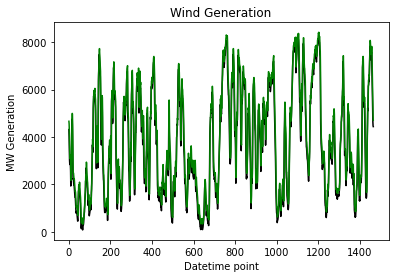

In [24]:
pyplot.plot(testing_actual, color='black')
pyplot.plot(predictions, color='green')

pyplot.xlabel('Datetime point')
pyplot.ylabel('MW Generation')
pyplot.title('Wind Generation')
pyplot.show()


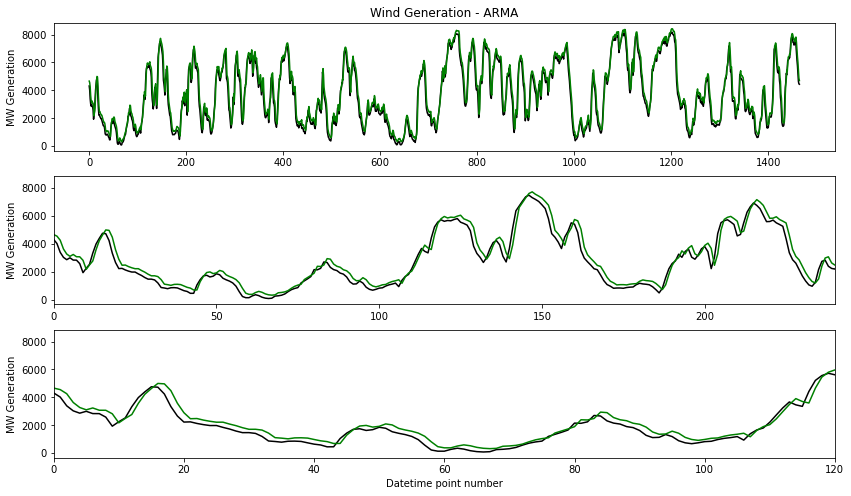

In [29]:
plot = pyplot.figure(figsize=(14,8))

ax1 = plot.add_subplot(311)
pyplot.plot(testing_actual, color='black')
pyplot.plot(predictions, color='green')
pyplot.ylabel('MW Generation')
pyplot.title('Wind Generation - ARMA')
#
ax2 = plot.add_subplot(312)
pyplot.plot(testing_actual, color='black')
pyplot.plot(predictions, color='green')
ax2.set_xlim([0, 240])
pyplot.ylabel('MW Generation')

#
ax3 = plot.add_subplot(313)
pyplot.plot(testing_actual, color='black')
pyplot.plot(predictions, color='green')
ax3.set_xlim([0, 120])
pyplot.xlabel('Datetime point number')
pyplot.ylabel('MW Generation')

pyplot.savefig('MA_Graph.png')